# Gradient Descent

En este _notebook_ vamos a aprender a programar el método de _Gradient Descent_. Vamos a partir generando datos que se ven lineales.

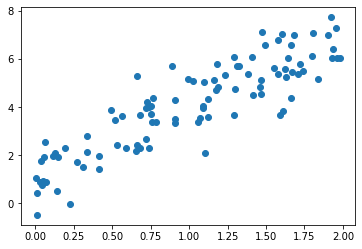

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Queremos un dataset de 100 muestras
X = 2*np.random.rand(100, 1)
y = 1 + 3*X + np.random.randn(100, 1)

plt.scatter(X, y)

Ahora necesitamos generar la matriz `X_b`, que es la matriz de features pero con el 1s en la primera columna.

In [2]:
X_b = np.c_[np.ones((100, 1)), X]

Y ahora graficaremos el MSE en función de $\beta_0$ y $\beta_1$

In [3]:
# Vamos a crear las combinaciones posibles de B
B0 = np.arange(-10, 10, 0.25)
B1 = np.arange(-10, 10, 0.25)

B0, B1 = np.meshgrid(B0, B1)

Z = []
for i in range(B0.shape[0]):
    Z_row = []
    for j in range(B0.shape[1]):
        sum_row = 0
        for k in range(X_b.shape[0]):
            sum_row += (B0[i, j]*X_b[k, 0] + B1[i, j]*X_b[k, 1] - y[k])**2
        sum_row = (1/100) * sum_row
        Z_row.append(float(sum_row))
    Z.append(Z_row)

Z = np.array(Z)

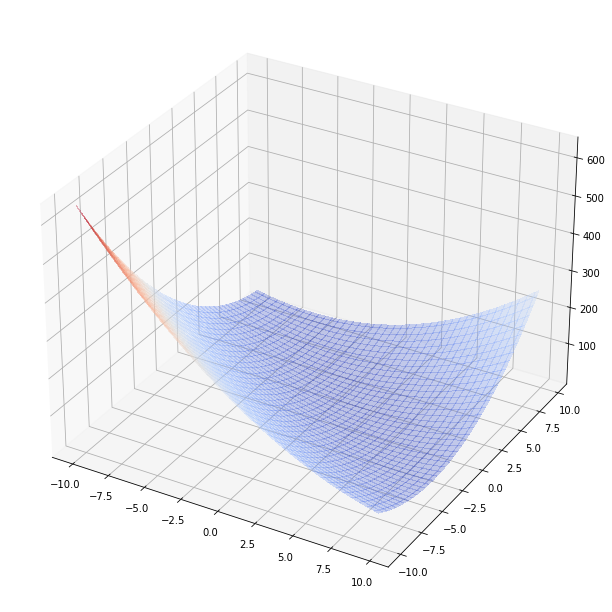

In [4]:
from matplotlib import cm

plt.rcParams['figure.figsize'] = [11, 11]


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(B0, B1, Z, linewidth=0, antialiased=False, alpha=0.3, cmap=cm.coolwarm)

plt.show()

Ahora vamos a implementar el algoritmo _Gradient Descent_.

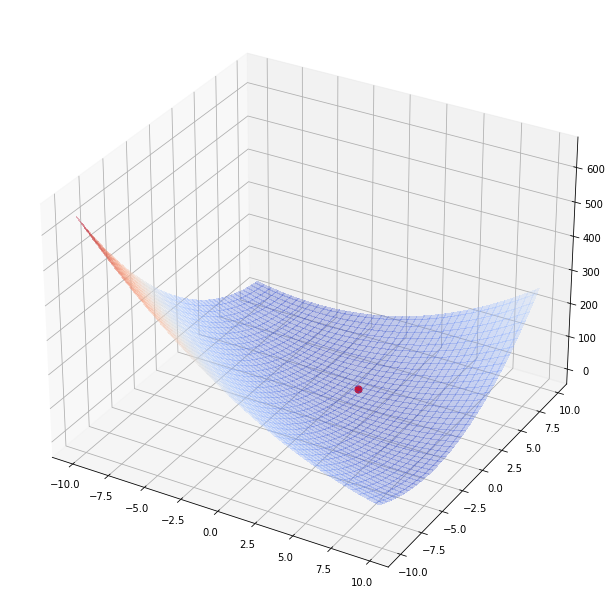

In [35]:
eta = 0.1
n_iterations = 100

# Inicializamos valores de Beta random
beta = np.random.randn(2, 1)

# Hacemos n_iterations iteraciones del algoritmo de Gradient Descent
for iteration in range(n_iterations):
    # Esta es la derivada, dado que tenemos 100 muestras
    gradients = 2/100 * X_b.T.dot(X_b.dot(beta) - y)
    # Cambiamos el beta según la tasa de aprendizaje
    beta = beta - eta * gradients

# Iteramos sobre todo el dataset para ver
# cuanto vale nuestra función objetivo
sum_row = 0
for k in range(X_b.shape[0]):
    sum_row += (beta[0]*X_b[k, 0] + beta[1]*X_b[k, 1] - y[k])**2

# Recordemos que al ser 100 muestras dividimos
# por 100 al estar usando el MSE
sum_row = (1/100) * sum_row
    
    
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(beta[0], beta[1], sum_row, zdir='z', color="red", s=50)
surf = ax.plot_surface(B0, B1, Z, linewidth=1, antialiased=False, alpha=0.3, cmap=cm.coolwarm)

plt.show()

Ahora veamos los valores de beta después de estas 100 iteraciones.

In [36]:
beta

array([[1.27919863],
       [2.76730075]])

Ahora veamos cómo cambia de iteración en iteración.

In [40]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

eta = 0.1
max_iter = 100

beta = np.random.randn(2,1)
# beta = np.array([-9, -9]).reshape(2,1)

beta_list = [beta]
for iteration in range(max_iter + 1):
    gradients = 2/100 * X_b.T.dot(X_b.dot(beta) - y)
    beta = beta - eta * gradients
    beta_list.append(beta)


def f_widget(n_iterations):
    beta = beta_list[n_iterations]
    sum_row = 0
    for k in range(X_b.shape[0]):
        sum_row += (beta[0]*X_b[k, 0] + beta[1]*X_b[k, 1] - y[k])**2

    sum_row = (1/100) * sum_row
    
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(beta[0], beta[1], sum_row, zdir='z', color="red", s=50)
    surf = ax.plot_surface(B0, B1, Z, linewidth=1, antialiased=False, alpha=0.3, cmap=cm.coolwarm)
    plt.show()

interact(f_widget, n_iterations=widgets.IntSlider(min=0, max=max_iter, step=1, value=0));

interactive(children=(IntSlider(value=0, description='n_iterations'), Output()), _dom_classes=('widget-interac…

## Optimizaciones al _Gradient Descent_

El problema con el método de _Gradient Descent_ es que en cada iteración computa el gradiente usando **todos los elementos del _set_ de entrenamiento**, que también lo hace lento cuando el _set_ de entrenamiento es muy grande. Por esto existen optimizaciones que vale la pena mencionar.

### Stochastic Gradient Descent (SGD)

El método de Stochastic Gradient Descent va tomando solo una de las derivadas parciales (de forma aleatoria) y en base a eso estima el gradiente. Esto nospermite que sea más rápido, que use menos memoria, a cambio de que sea más irregular. Ojo que este algoritmo siempre tenderá a moverse y no se "estabilizará" una vez que encuentre el mínimo, pero de todas formas, este es un buen algoritmo para escapar de mínimos locales.

Además aquí vamos a utilizar el concepto de **_learning schedule_** que corresponde a una forma de partir con una _learning rate_ alta y luego irla disminuyendo. Esto permite un alto progreso al inicio (y el escape de mínimos locales), y después al disminuir se acerca mejor al mínimo global. Vamos a programar esto.

In [39]:
# Definimos el número de épocas
n_epochs = 50

# Definimos hiperparámetros de nuestro learning schedule
t0 = 5
t1 = 50

# Definimos un learning schedule sencillo
def learning_schedule(t):
    return t0/(t + t1)

beta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    # Por convención, en cada época tomamos un número de muestras
    # igual al número total de observaciones
    for i in range(100):
        random_index = np.random.randint(100) # Escogemos una de las 100 observaciones
        x_i = X_b[random_index:random_index + 1]
        y_i = y[random_index:random_index + 1]
        gradients = 2*x_i.T.dot(x_i.dot(beta) - y_i)
        # Calculamos el learning rate en base a la funcion learning schedule
        eta = learning_schedule(epoch*100 + i) # El 100 viene del número de observaciones
        beta = beta - eta*gradients # Mismo método de antes, solo que ahora vamos de a una observación
        
beta

array([[1.17210324],
       [2.85665716]])

Notamos que este algoritmo funciona por épocas. En este caso tenemos 50 épocas. Por convención, en cada época tomaremos un número de muestras igual al número de observaciones. Es importante ver que ahora en vez de calcular el gradiente con una multiplicación de matrices con todo el dataset, solamente tomamos una observación al azar de todas nuestras observaciones. Cada una de estas muestras (100 muestras por época en este caso) nos sirve para ir modificando nuestro valor de $\beta$. 

Si revisamos los valores de beta, vemos que este método no se comporta nada mal a pesar de haber revisado menos veces el _dataset_ completo. Ahora vamos a ver cómo se comporta nuestro algoritmo para cada época.

In [52]:
# Definimos el número de épocas
n_epochs = 50

# Definimos hiperparámetros de nuestro learning schedule
t0 = 5
t1 = 50

# Definimos un learning schedule sencillo
def learning_schedule(t):
    return t0/(t + t1)

beta = np.random.randn(2, 1)
# beta = np.array([-9, -9])

beta_list = [beta]
for epoch in range(n_epochs):
    # Por convención, en cada época tomamos un número de muestras
    # igual al número total de observaciones
    for i in range(100):
        random_index = np.random.randint(100) # Escogemos una de las 100 observaciones
        x_i = X_b[random_index:random_index + 1]
        y_i = y[random_index:random_index + 1]
        gradients = 2*x_i.T.dot(x_i.dot(beta) - y_i)
        # Calculamos el learning rate en base a la funcion learning schedule
        eta = learning_schedule(epoch*100 + i) # El 100 viene del número de observaciones
        # eta = 0.1
        beta = beta - eta*gradients # Mismo método de antes, solo que ahora vamos de a una observación
    
    beta_list.append(beta)
    
def f_widget_sgd(n_iterations):
    beta = beta_list[n_iterations]
    sum_row = 0
    for k in range(X_b.shape[0]):
        sum_row += (beta[0]*X_b[k, 0] + beta[1]*X_b[k, 1] - y[k])**2

    sum_row = (1/100) * sum_row
    
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(beta[0], beta[1], sum_row, zdir='z', color="red", s=50)
    surf = ax.plot_surface(B0, B1, Z, linewidth=1, antialiased=False, alpha=0.3, cmap=cm.coolwarm)
    plt.show()

interact(f_widget_sgd, n_iterations=widgets.IntSlider(min=0, max=n_epochs, step=1, value=0));

interactive(children=(IntSlider(value=0, description='n_iterations', max=50), Output()), _dom_classes=('widget…

Como vemos, los primeros pasos son bastante más grande que los últimos. Sin embargo, este algoritmo siempre escoge moverse, y en las últimas épocas solo atenuamos esto por lo bajo de la _learning rate_.

### Mini-batch Gradient Descent

Este último algoritmo mezcla el concepto del Gradient Descent junto con el Stochastic Gradient Descent. Aquí en vez de en cada época entrenar con todo el _dataset_ como en el algoritmo original, o simplemente tomar una instancia como el algoritmo SGD, **escogemos computar el gradiente sobre subconjuntos aleatorios de los datos**, llamadas _mini-batches_. Este algoritmo es particularmente rápido cuando podemos hacer optimización por hardware utilizando GPUs. Esta versión del algoritmo no la vamos a programar ahora, pero la vamos a retomar al momento de estudiar redes neuronales.